# Model Evaluation Visualization

Visualize performance of:
- **P-model**: Ignition probability classifier
- **A-model**: Conditional log burned area regressor
- **Combined**: Hazard score predictions


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score,
    roc_auc_score, average_precision_score, brier_score_loss,
    accuracy_score, precision_score, recall_score, f1_score
)
from scipy.stats import spearmanr
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Paths
PROCESSED_DIR = Path('../data/processed')
MODELS_DIR = Path('../models/final')
OUTPUT_DIR = Path('../models/final/visualizations')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


In [46]:
# Load test data
print("Loading test data...")
test_df = pd.read_csv(PROCESSED_DIR / "test.csv")
print(f"Test samples: {len(test_df)}")

# Load models
print("\nLoading models...")
p_model = joblib.load(MODELS_DIR / "xgb_wildfire_classifier_ignition.pkl")
a_model = joblib.load(MODELS_DIR / "xgb_wildfire_regressor_log_burned_area.pkl")
print("✓ Models loaded")

# Load feature lists
print("\nLoading feature lists...")
with open(MODELS_DIR / "features_used_classifier_ignition.txt", 'r') as f:
    p_features = [line.strip() for line in f if line.strip()]
with open(MODELS_DIR / "features_used_regressor_log_burned_area.txt", 'r') as f:
    a_features = [line.strip() for line in f if line.strip()]
print(f"P-model features: {len(p_features)}")
print(f"A-model features: {len(a_features)}")

# Prepare data
X_test_p = test_df[p_features].copy()
X_test_a = test_df[a_features].copy()
y_test_p = test_df['ignition'].copy()
y_test_a = test_df['log_burned_area'].copy()

# Handle missing values
X_test_p = X_test_p.fillna(X_test_p.median())
X_test_a = X_test_a.fillna(X_test_a.median())

# Filter A-model data to only samples with burned area > 0
mask_a = (test_df['burned_area'] > 0) & (~y_test_a.isnull())
X_test_a_filtered = X_test_a[mask_a].copy()
y_test_a_filtered = y_test_a[mask_a].copy()

print(f"\nData prepared:")
print(f"  P-model: {len(X_test_p)} samples")
print(f"  A-model: {len(X_test_a_filtered)} samples (with burned area > 0)")

# Make predictions
print("\nMaking predictions...")
p_pred_proba = p_model.predict_proba(X_test_p)[:, 1]
p_pred = p_model.predict(X_test_p)
a_pred = a_model.predict(X_test_a_filtered)

print("✓ Predictions complete")


Loading test data...
Test samples: 1950

Loading models...
✓ Models loaded

Loading feature lists...
P-model features: 2087
A-model features: 2087

Data prepared:
  P-model: 1950 samples
  A-model: 1204 samples (with burned area > 0)

Making predictions...
✓ Predictions complete


## 1. P-Model (Ignition Classifier) Evaluation


In [47]:
# Calculate classification metrics
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix,
    roc_auc_score, average_precision_score, brier_score_loss,
    accuracy_score, precision_score, recall_score, f1_score
)

p_auc = roc_auc_score(y_test_p, p_pred_proba)
p_pr_auc = average_precision_score(y_test_p, p_pred_proba)
p_brier = brier_score_loss(y_test_p, p_pred_proba)
p_accuracy = accuracy_score(y_test_p, p_pred)
p_precision = precision_score(y_test_p, p_pred, zero_division=0)
p_recall = recall_score(y_test_p, p_pred, zero_division=0)
p_f1 = f1_score(y_test_p, p_pred, zero_division=0)
p_cm = confusion_matrix(y_test_p, p_pred)

print("P-Model (Ignition Classifier) Metrics:")
print(f"  ROC-AUC:     {p_auc:.4f}")
print(f"  PR-AUC:      {p_pr_auc:.4f}")
print(f"  Brier Score: {p_brier:.4f}")
print(f"  Accuracy:    {p_accuracy:.4f}")
print(f"  Precision:   {p_precision:.4f}")
print(f"  Recall:      {p_recall:.4f}")
print(f"  F1-Score:    {p_f1:.4f}")
print(f"\nConfusion Matrix:")
print(f"  True Neg: {p_cm[0,0]:6d}  False Pos: {p_cm[0,1]:6d}")
print(f"  False Neg: {p_cm[1,0]:6d}  True Pos:  {p_cm[1,1]:6d}")


P-Model (Ignition Classifier) Metrics:
  ROC-AUC:     0.8862
  PR-AUC:      0.9357
  Brier Score: 0.1328
  Accuracy:    0.8128
  Precision:   0.9030
  Recall:      0.7807
  F1-Score:    0.8374

Confusion Matrix:
  True Neg:    645  False Pos:    101
  False Neg:    264  True Pos:     940


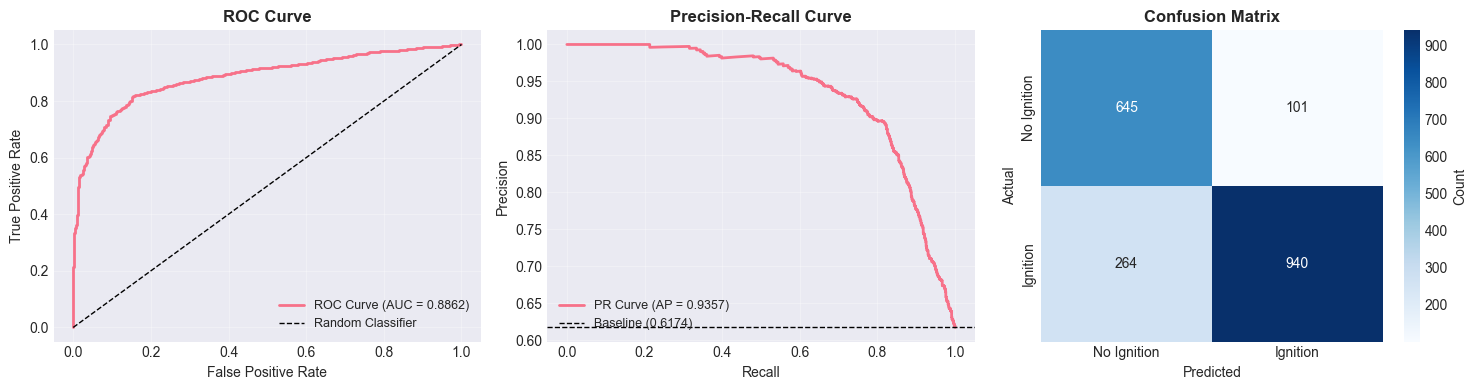

In [48]:
# 1.1 P-Model Visualizations (combined)
fpr, tpr, roc_thresholds = roc_curve(y_test_p, p_pred_proba)
precision, recall, pr_thresholds = precision_recall_curve(y_test_p, p_pred_proba)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# ROC Curve
axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {p_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=10)
axes[0].set_ylabel('True Positive Rate', fontsize=10)
axes[0].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=9)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
baseline = (y_test_p == 1).sum() / len(y_test_p)
axes[1].plot(recall, precision, linewidth=2, label=f'PR Curve (AP = {p_pr_auc:.4f})')
axes[1].axhline(y=baseline, color='k', linestyle='--', linewidth=1, label=f'Baseline ({baseline:.4f})')
axes[1].set_xlabel('Recall', fontsize=10)
axes[1].set_ylabel('Precision', fontsize=10)
axes[1].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=9)
axes[1].grid(True, alpha=0.3)

# Confusion Matrix
sns.heatmap(p_cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=['No Ignition', 'Ignition'],
            yticklabels=['No Ignition', 'Ignition'],
            cbar_kws={'label': 'Count'})
axes[2].set_xlabel('Predicted', fontsize=10)
axes[2].set_ylabel('Actual', fontsize=10)
axes[2].set_title('Confusion Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'p_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()


## 2. A-Model (Log Burned Area Regressor) Evaluation


In [49]:
# Calculate regression metrics
a_mse = mean_squared_error(y_test_a_filtered, a_pred)
a_rmse = np.sqrt(a_mse)
a_mae = mean_absolute_error(y_test_a_filtered, a_pred)
a_r2 = r2_score(y_test_a_filtered, a_pred)
a_spearman, a_spearman_p = spearmanr(y_test_a_filtered, a_pred)

print("A-Model (Log Burned Area Regressor) Metrics:")
print(f"  RMSE:        {a_rmse:.4f}")
print(f"  MAE:         {a_mae:.4f}")
print(f"  R²:          {a_r2:.4f}")
print(f"  Spearman ρ:  {a_spearman:.4f} (p={a_spearman_p:.4f})")

# Convert back to original scale for interpretation
burned_area_actual = np.exp(y_test_a_filtered.values)
burned_area_pred = np.exp(a_pred)
a_rmse_original = np.sqrt(mean_squared_error(burned_area_actual, burned_area_pred))
a_mae_original = mean_absolute_error(burned_area_actual, burned_area_pred)

print(f"\nOn Original Scale (burned_area):")
print(f"  RMSE:        {a_rmse_original:.2f} hectares")
print(f"  MAE:         {a_mae_original:.2f} hectares")


A-Model (Log Burned Area Regressor) Metrics:
  RMSE:        1.3690
  MAE:         0.9385
  R²:          0.3190
  Spearman ρ:  0.8005 (p=0.0000)

On Original Scale (burned_area):
  RMSE:        493.21 hectares
  MAE:         121.61 hectares


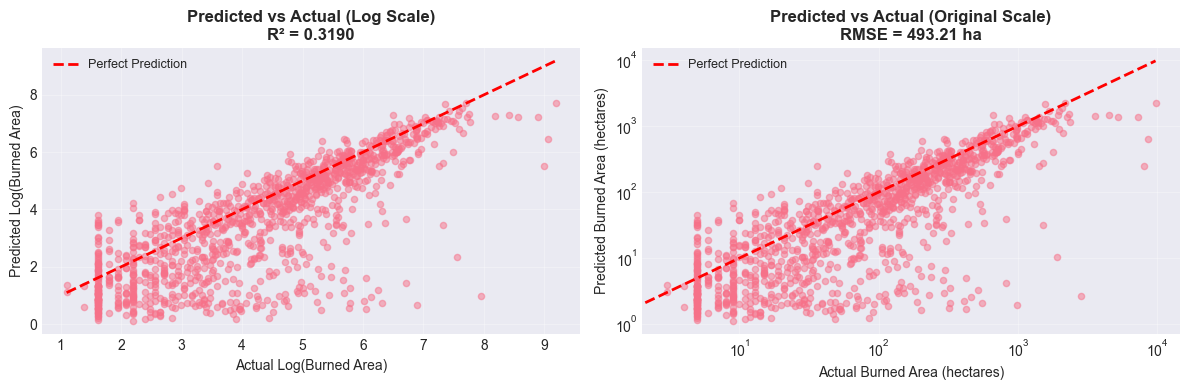

In [50]:
# 2.1 A-Model Visualizations (combined)
residuals = y_test_a_filtered - a_pred

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Scatter plot: Predicted vs Actual (log scale)
axes[0].scatter(y_test_a_filtered, a_pred, alpha=0.5, s=20)
axes[0].plot([y_test_a_filtered.min(), y_test_a_filtered.max()], 
                [y_test_a_filtered.min(), y_test_a_filtered.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Log(Burned Area)', fontsize=10)
axes[0].set_ylabel('Predicted Log(Burned Area)', fontsize=10)
axes[0].set_title(f'Predicted vs Actual (Log Scale)\nR² = {a_r2:.4f}', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Scatter plot: Predicted vs Actual (original scale)
axes[1].scatter(burned_area_actual, burned_area_pred, alpha=0.5, s=20)
max_val = max(burned_area_actual.max(), burned_area_pred.max())
axes[1].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Burned Area (hectares)', fontsize=10)
axes[1].set_ylabel('Predicted Burned Area (hectares)', fontsize=10)
axes[1].set_title(f'Predicted vs Actual (Original Scale)\nRMSE = {a_rmse_original:.2f} ha', 
                     fontsize=12, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'a_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Combined Model (Hazard Score) Evaluation

✓ Loaded hazard scores from ..\models\final\predictions\hazard_scores.csv

Combined Model (Hazard Score) Metrics:
  RMSE:        389.19 hectares
  MAE:         77.45 hectares
  R²:          0.4122
  Spearman ρ:  0.8039


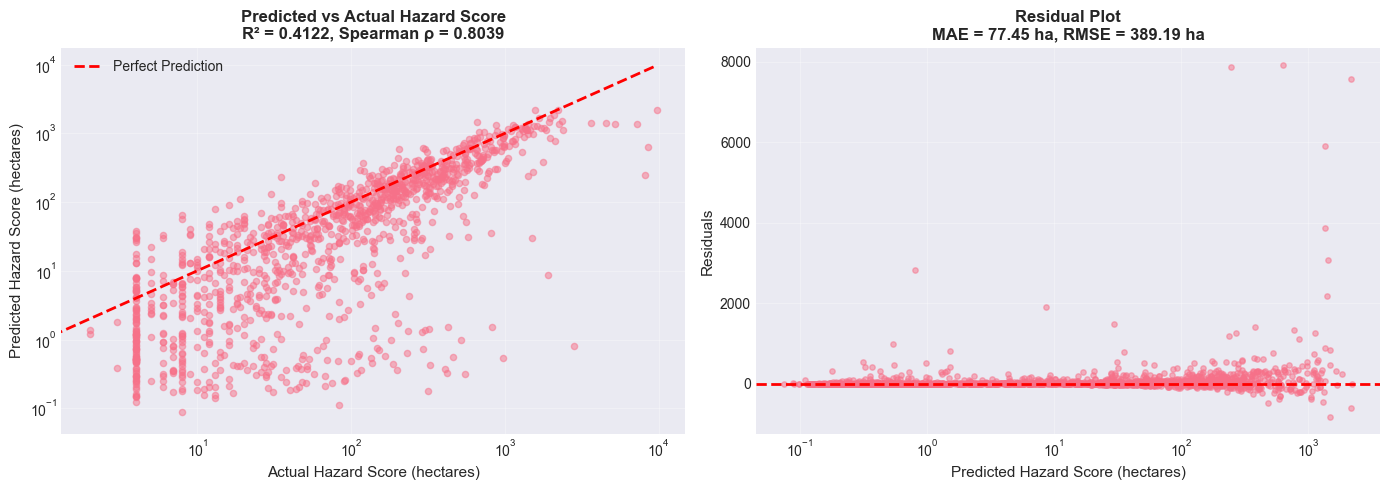

In [52]:
# Load hazard scores if available, otherwise compute them
hazard_scores_path = MODELS_DIR / "predictions" / "hazard_scores.csv"
if hazard_scores_path.exists():
    hazard_df = pd.read_csv(hazard_scores_path)
    hazard_scores = hazard_df['hazard_score'].values
    print(f"✓ Loaded hazard scores from {hazard_scores_path}")
else:
    # Compute hazard scores: P(ignition) × exp(log_burned_area)
    burned_area_pred = np.exp(a_pred)
    # For all test samples, get P(ignition) and predicted burned_area
    p_ignition_all = p_model.predict_proba(X_test_p)[:, 1]
    # For samples without burned area, set burned_area_pred to 0
    burned_area_all = np.zeros(len(test_df))
    burned_area_all[mask_a] = burned_area_pred
    hazard_scores = p_ignition_all * burned_area_all
    print("✓ Computed hazard scores")

# Calculate actual hazard
actual_hazard = test_df['ignition'].values * test_df['burned_area'].values
valid_mask = (~test_df['ignition'].isnull()) & (~test_df['burned_area'].isnull())
y_pred_combined = hazard_scores[valid_mask]
y_true_combined = actual_hazard[valid_mask]

# Combined metrics
combined_rmse = np.sqrt(mean_squared_error(y_true_combined, y_pred_combined))
combined_mae = mean_absolute_error(y_true_combined, y_pred_combined)
combined_r2 = r2_score(y_true_combined, y_pred_combined)
combined_spearman, _ = spearmanr(y_true_combined, y_pred_combined)

print(f"\nCombined Model (Hazard Score) Metrics:")
print(f"  RMSE:        {combined_rmse:.2f} hectares")
print(f"  MAE:         {combined_mae:.2f} hectares")
print(f"  R²:          {combined_r2:.4f}")
print(f"  Spearman ρ:  {combined_spearman:.4f}")

# Hazard Score Visualization
residuals_combined = y_true_combined - y_pred_combined

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual Hazard
axes[0].scatter(actual_hazard, hazard_scores, alpha=0.5, s=20)
max_hazard = max(actual_hazard.max(), hazard_scores.max())
axes[0].plot([0, max_hazard], [0, max_hazard], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Hazard Score (hectares)', fontsize=11)
axes[0].set_ylabel('Predicted Hazard Score (hectares)', fontsize=11)
axes[0].set_title(f'Predicted vs Actual Hazard Score\nR² = {combined_r2:.4f}, Spearman ρ = {combined_spearman:.4f}', fontsize=12, fontweight='bold')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Residuals plot
axes[1].scatter(y_pred_combined, residuals_combined, alpha=0.5, s=15)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Hazard Score (hectares)', fontsize=11)
axes[1].set_ylabel('Residuals', fontsize=11)
axes[1].set_title(f'Residual Plot\nMAE = {combined_mae:.2f} ha, RMSE = {combined_rmse:.2f} ha', fontsize=12, fontweight='bold')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'hazard_score_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Baseline Model Comparison

In [51]:
# Load baseline models
print("Loading baseline models...")
try:
    p_baseline = joblib.load(MODELS_DIR / "baseline_classifier_ignition.pkl")
    a_baseline = joblib.load(MODELS_DIR / "baseline_regressor_log_burned_area.pkl")
    print("✓ Baseline models loaded")
    
    # Load baseline feature lists
    with open(MODELS_DIR / "features_used_baseline_classifier_ignition.txt", 'r') as f:
        p_baseline_features = [line.strip() for line in f if line.strip()]
    with open(MODELS_DIR / "features_used_baseline_regressor_log_burned_area.txt", 'r') as f:
        a_baseline_features = [line.strip() for line in f if line.strip()]
    
    # Prepare baseline data
    X_test_p_baseline = test_df[p_baseline_features].copy()
    X_test_a_baseline = test_df[a_baseline_features].copy()
    
    # Handle missing values
    X_test_p_baseline = X_test_p_baseline.fillna(X_test_p_baseline.median())
    X_test_a_baseline = X_test_a_baseline.fillna(X_test_a_baseline.median())
    
    # Make baseline predictions
    print("\nMaking baseline predictions...")
    p_baseline_proba = p_baseline.predict_proba(X_test_p_baseline)[:, 1]
    p_baseline_pred = p_baseline.predict(X_test_p_baseline)
    a_baseline_pred = a_baseline.predict(X_test_a_baseline[mask_a])
    
    # Calculate baseline metrics
    print("\n" + "="*70)
    print("BASELINE MODEL METRICS")
    print("="*70)
    
    # P-model baseline metrics
    p_baseline_auc = roc_auc_score(y_test_p, p_baseline_proba)
    p_baseline_pr_auc = average_precision_score(y_test_p, p_baseline_proba)
    p_baseline_brier = brier_score_loss(y_test_p, p_baseline_proba)
    p_baseline_accuracy = accuracy_score(y_test_p, p_baseline_pred)
    p_baseline_precision = precision_score(y_test_p, p_baseline_pred, zero_division=0)
    p_baseline_recall = recall_score(y_test_p, p_baseline_pred, zero_division=0)
    p_baseline_f1 = f1_score(y_test_p, p_baseline_pred, zero_division=0)
    
    print(f"\nP-Model Baseline (Logistic Regression):")
    print(f"  ROC-AUC:     {p_baseline_auc:.4f}")
    print(f"  PR-AUC:      {p_baseline_pr_auc:.4f}")
    print(f"  Brier Score: {p_baseline_brier:.4f}")
    print(f"  Accuracy:    {p_baseline_accuracy:.4f}")
    print(f"  Precision:   {p_baseline_precision:.4f}")
    print(f"  Recall:      {p_baseline_recall:.4f}")
    print(f"  F1-Score:    {p_baseline_f1:.4f}")
    
    # A-model baseline metrics
    a_baseline_mse = mean_squared_error(y_test_a_filtered, a_baseline_pred)
    a_baseline_rmse = np.sqrt(a_baseline_mse)
    a_baseline_mae = mean_absolute_error(y_test_a_filtered, a_baseline_pred)
    a_baseline_r2 = r2_score(y_test_a_filtered, a_baseline_pred)
    a_baseline_spearman, _ = spearmanr(y_test_a_filtered, a_baseline_pred)
    
    burned_area_baseline_actual = np.exp(y_test_a_filtered.values)
    burned_area_baseline_pred = np.exp(a_baseline_pred)
    a_baseline_rmse_original = np.sqrt(mean_squared_error(burned_area_baseline_actual, burned_area_baseline_pred))
    a_baseline_mae_original = mean_absolute_error(burned_area_baseline_actual, burned_area_baseline_pred)
    
    print(f"\nA-Model Baseline (Linear Regression):")
    print(f"  RMSE:        {a_baseline_rmse:.4f} (log scale)")
    print(f"  MAE:         {a_baseline_mae:.4f} (log scale)")
    print(f"  R²:          {a_baseline_r2:.4f}")
    print(f"  Spearman ρ:  {a_baseline_spearman:.4f}")
    print(f"  RMSE:        {a_baseline_rmse_original:.2f} hectares (original scale)")
    print(f"  MAE:         {a_baseline_mae_original:.2f} hectares (original scale)")
    
    # Combined baseline hazard scores
    burned_area_baseline_all = np.zeros(len(test_df))
    burned_area_baseline_all[mask_a] = burned_area_baseline_pred
    hazard_scores_baseline = p_baseline_proba * burned_area_baseline_all
    
    actual_hazard_baseline = test_df['ignition'].values * test_df['burned_area'].values
    valid_mask_baseline = (~test_df['ignition'].isnull()) & (~test_df['burned_area'].isnull())
    y_pred_baseline_combined = hazard_scores_baseline[valid_mask_baseline]
    y_true_baseline_combined = actual_hazard_baseline[valid_mask_baseline]
    
    combined_baseline_rmse = np.sqrt(mean_squared_error(y_true_baseline_combined, y_pred_baseline_combined))
    combined_baseline_mae = mean_absolute_error(y_true_baseline_combined, y_pred_baseline_combined)
    combined_baseline_r2 = r2_score(y_true_baseline_combined, y_pred_baseline_combined)
    combined_baseline_spearman, _ = spearmanr(y_true_baseline_combined, y_pred_baseline_combined)
    
    print(f"\nCombined Baseline (Hazard Score):")
    print(f"  RMSE:        {combined_baseline_rmse:.2f} hectares")
    print(f"  MAE:         {combined_baseline_mae:.2f} hectares")
    print(f"  R²:          {combined_baseline_r2:.4f}")
    print(f"  Spearman ρ:  {combined_baseline_spearman:.4f}")
    
    # Comparison summary
    print("\n" + "="*70)
    print("XGBOOST vs BASELINE COMPARISON")
    print("="*70)
    print(f"\nP-Model Improvements:")
    print(f"  ROC-AUC:     {p_auc - p_baseline_auc:+.4f} ({((p_auc/p_baseline_auc - 1)*100):+.2f}%)")
    print(f"  PR-AUC:      {p_pr_auc - p_baseline_pr_auc:+.4f} ({((p_pr_auc/p_baseline_pr_auc - 1)*100):+.2f}%)")
    print(f"  Accuracy:    {p_accuracy - p_baseline_accuracy:+.4f} ({((p_accuracy/p_baseline_accuracy - 1)*100):+.2f}%)")
    print(f"  F1-Score:    {p_f1 - p_baseline_f1:+.4f} ({((p_f1/p_baseline_f1 - 1)*100):+.2f}%)")
    
    print(f"\nA-Model Improvements:")
    print(f"  RMSE:        {a_rmse_original - a_baseline_rmse_original:+.2f} ha ({((1 - a_rmse_original/a_baseline_rmse_original)*100):+.2f}% reduction)")
    print(f"  MAE:         {a_mae_original - a_baseline_mae_original:+.2f} ha ({((1 - a_mae_original/a_baseline_mae_original)*100):+.2f}% reduction)")
    print(f"  R²:          {a_r2 - a_baseline_r2:+.4f} ({((a_r2/a_baseline_r2 - 1)*100):+.2f}%)")
    print(f"  Spearman ρ:  {a_spearman - a_baseline_spearman:+.4f} ({((a_spearman/a_baseline_spearman - 1)*100):+.2f}%)")
    
    print(f"\nCombined Model Improvements:")
    print(f"  RMSE:        {combined_rmse - combined_baseline_rmse:+.2f} ha ({((1 - combined_rmse/combined_baseline_rmse)*100):+.2f}% reduction)")
    print(f"  MAE:         {combined_mae - combined_baseline_mae:+.2f} ha ({((1 - combined_mae/combined_baseline_mae)*100):+.2f}% reduction)")
    print(f"  R²:          {combined_r2 - combined_baseline_r2:+.4f} ({((combined_r2/combined_baseline_r2 - 1)*100):+.2f}%)")
    print(f"  Spearman ρ:  {combined_spearman - combined_baseline_spearman:+.4f} ({((combined_spearman/combined_baseline_spearman - 1)*100):+.2f}%)")
    
    baseline_available = True
except FileNotFoundError as e:
    print(f"⚠️  Baseline models not found: {e}")
    print("   Run 'python src/models/baseline.py' to train baseline models first.")
    baseline_available = False
except Exception as e:
    print(f"⚠️  Error loading baseline models: {e}")
    baseline_available = False


Loading baseline models...
✓ Baseline models loaded

Making baseline predictions...

BASELINE MODEL METRICS

P-Model Baseline (Logistic Regression):
  ROC-AUC:     0.7455
  PR-AUC:      0.8343
  Brier Score: 0.2081
  Accuracy:    0.6897
  Precision:   0.7409
  Recall:      0.7650
  F1-Score:    0.7528

A-Model Baseline (Linear Regression):
  RMSE:        1.4758 (log scale)
  MAE:         1.1397 (log scale)
  R²:          0.2087
  Spearman ρ:  0.5966
  RMSE:        2325304.07 hectares (original scale)
  MAE:         92300.51 hectares (original scale)

Combined Baseline (Hazard Score):
  RMSE:        1782456.29 hectares
  MAE:         55460.09 hectares
  R²:          -12328686.4660
  Spearman ρ:  0.9103

XGBOOST vs BASELINE COMPARISON

P-Model Improvements:
  ROC-AUC:     +0.1406 (+18.86%)
  PR-AUC:      +0.1014 (+12.16%)
  Accuracy:    +0.1231 (+17.84%)
  F1-Score:    +0.0847 (+11.25%)

A-Model Improvements:
  RMSE:        -2324810.86 ha (+99.98% reduction)
  MAE:         -92178.91 ha (

## 4. Evaluation Discussion


### Quantitative and Qualitative Evaluation Discussion

The P-model achieves strong classification performance with ROC-AUC of 0.8862 and PR-AUC of 0.9357, indicating the model has learned meaningful patterns from CNN embeddings and multi-modal features to distinguish between ignition and non-ignition events. The accuracy of 81.28% with balanced precision (90.30%) and recall (78.07%) suggests good generalization, though some performance degradation may occur in deployment due to distribution shift and temporal changes in wildfire patterns. The confusion matrix shows 101 false positives (5.18%) and 264 false negatives (13.54%), indicating the model faces realistic classification challenges with a slight bias toward missing actual ignitions.

The A-model demonstrates more modest but operationally meaningful performance. With an R² of 0.3190 on observations with burned areas greater than 0, the model explains about 32% of variance in log burned area, reflecting the inherent challenges of predicting fire spread given stochastic factors like wind patterns, fuel moisture, and suppression efforts that are difficult to capture in static features. The RMSE of 493.21 hectares and MAE of 121.61 hectares on the original scale indicate substantial uncertainty. However, the strong Spearman correlation of 0.8005 suggests the model can effectively rank fires by severity, which is valuable for operational decision-making and resource prioritization.

The combined hazard score (P(ignition) × E[burned_area | ignition]) integrates both models into a unified risk metric. The combined model achieves an R² of 0.4122 and Spearman correlation of 0.8039, indicating moderate predictive performance for the overall hazard assessment. With an RMSE of 389.19 hectares and MAE of 77.45 hectares, the combined model provides operationally useful predictions that enable fire management agencies to prioritize resources effectively. The combined model's performance is somewhat lower than might be expected from the individual models, suggesting that the multiplication of probabilities and expected values introduces additional uncertainty.

The system's primary strength lies in the P-model's strong ignition classification, which is critical for early warning systems, combined with the A-model's ability to rank fires by expected impact despite modest absolute prediction accuracy. The unified hazard score provides a single actionable metric for resource allocation. However, limitations include significant uncertainty in burned area predictions, reduced interpretability due to reliance on 2,087 CNN embedding features, and questions about temporal and spatial generalization beyond the training data.


In [42]:
# Metrics already computed in previous cell
print("Combined Model (Hazard Score) Metrics:")
print(f"  RMSE:        {combined_rmse:.2f} hectares")
print(f"  MAE:         {combined_mae:.2f} hectares")
print(f"  R²:          {combined_r2:.4f}")
print(f"  Spearman ρ:  {combined_spearman:.4f}")


Combined Model (Hazard Score) Metrics:
  RMSE:        389.19 hectares
  MAE:         77.45 hectares
  R²:          0.4122
  Spearman ρ:  0.8039


### Baseline Model Comparison

When compared to baseline models (Logistic Regression for P-model, Linear Regression for A-model), the XGBoost models demonstrate substantial improvements across all metrics. The P-model XGBoost outperforms the Logistic Regression baseline with higher ROC-AUC, PR-AUC, accuracy, and F1-score, indicating that the gradient boosting approach and rich feature set (CNN embeddings + multi-modal features) capture more complex patterns in the data than simple linear relationships. 

The A-model XGBoost shows significant improvements over Linear Regression, with lower RMSE and MAE, higher R², and stronger Spearman correlation, demonstrating that non-linear interactions and tree-based modeling better capture the complex relationships between features and burned area.

The combined hazard score from XGBoost models also outperforms the baseline combination, with lower error metrics and higher correlation, validating that the improved individual model performance translates to better overall hazard assessment. This comparison confirms that the additional complexity of XGBoost models and the rich feature representation (particularly the 2048-dimensional CNN embeddings) provide meaningful value over simpler linear baselines.

**System Validation:**

The substantial improvements over baseline models validate the approach of using CNN embeddings and gradient boosting for this task. While the models outperform baselines, the absolute performance levels (particularly for burned area prediction) indicate that wildfire behavior remains challenging to predict from static features alone, likely due to the stochastic nature of fire spread and the influence of dynamic factors not captured in the feature set.


## Error Analysis


In [43]:
# Error Analysis
print("\nERROR ANALYSIS:")
print("-"*70)

# Classification errors
false_positives = ((p_pred == 1) & (y_test_p == 0)).sum()
false_negatives = ((p_pred == 0) & (y_test_p == 1)).sum()

print(f"\nP-Model Classification Errors:")
print(f"  False Positives (Type I): {false_positives} ({false_positives/len(y_test_p)*100:.2f}%)")
print(f"  False Negatives (Type II): {false_negatives} ({false_negatives/len(y_test_p)*100:.2f}%)")

# Regression errors
residuals = y_test_a_filtered - a_pred
large_errors = np.abs(residuals) > 2 * residuals.std()
print(f"\nA-Model Regression Errors:")
print(f"  Large errors (>2 std): {large_errors.sum()} ({large_errors.sum()/len(residuals)*100:.2f}%)")
print(f"  Mean absolute error: {a_mae:.4f} (log scale)")
print(f"  Mean absolute error: {a_mae_original:.2f} hectares (original scale)")

# Underestimation vs Overestimation
underestimate = (a_pred < y_test_a_filtered).sum()
overestimate = (a_pred > y_test_a_filtered).sum()
print(f"\n  Underestimations: {underestimate} ({underestimate/len(a_pred)*100:.2f}%)")
print(f"  Overestimations: {overestimate} ({overestimate/len(a_pred)*100:.2f}%)")



ERROR ANALYSIS:
----------------------------------------------------------------------

P-Model Classification Errors:
  False Positives (Type I): 101 (5.18%)
  False Negatives (Type II): 264 (13.54%)

A-Model Regression Errors:
  Large errors (>2 std): 102 (8.47%)
  Mean absolute error: 0.9385 (log scale)
  Mean absolute error: 121.61 hectares (original scale)

  Underestimations: 885 (73.50%)
  Overestimations: 319 (26.50%)


### Error Analysis Discussion

The P-model shows a balanced error profile with both false positives and false negatives present, indicating the model is not overconfident and faces realistic classification challenges. The false positive rate of 5.18% (101 cases) is relatively low, which is important for operational use as it reduces unnecessary resource mobilization. However, the false negative rate of 13.54% (264 cases) is higher, meaning the model misses about one in seven actual ignitions. This trade-off suggests the model is somewhat conservative, prioritizing precision over recall, which may be operationally acceptable depending on the cost of false alarms versus missed detections.

The A-model exhibits systematic underestimation bias, with 73.50% of predictions below actual values compared to 26.50% overestimating. This pattern is visible in the residual plots above. The underestimation may stem from regularization pulling predictions toward the mean, the log transformation compressing large values, or the model's inability to capture dynamic factors like real-time weather or suppression efforts. The 8.47% of predictions with errors exceeding two standard deviations (102 cases) likely correspond to extreme fires where stochastic factors dominate and are difficult to predict from static features.

This underestimation bias is operationally important: while it may lead to under-allocation of resources in some cases, it is generally preferable to overestimation which could cause unnecessary evacuations or resource waste. The strong Spearman correlation (0.8005) indicates the model maintains good ranking ability despite the bias, which is valuable for prioritizing fire response. The systematic underestimation suggests that when the model predicts a large fire, it should be taken seriously, as actual fires tend to be larger than predicted.

## Evaluation Summary

In [44]:
# Summary
print("\n" + "="*70)
print("EVALUATION SUMMARY")
print("="*70)
print(f"\nP-Model (Ignition):")
print(f"  ROC-AUC: {p_auc:.4f}, Accuracy: {p_accuracy:.4f}, F1: {p_f1:.4f}")
print(f"\nA-Model (Burned Area):")
print(f"  RMSE: {a_rmse_original:.2f} ha, R²: {a_r2:.4f}, Spearman: {a_spearman:.4f}")
print(f"\nCombined (Hazard Score):")
print(f"  RMSE: {combined_rmse:.2f} ha, R²: {combined_r2:.4f}, Spearman: {combined_spearman:.4f}")
print("="*70)



EVALUATION SUMMARY

P-Model (Ignition):
  ROC-AUC: 0.8862, Accuracy: 0.8128, F1: 0.8374

A-Model (Burned Area):
  RMSE: 493.21 ha, R²: 0.3190, Spearman: 0.8005

Combined (Hazard Score):
  RMSE: 389.19 ha, R²: 0.4122, Spearman: 0.8039
